In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from time import time

In [2]:
df = pd.read_csv('heart.csv')

In [5]:
df.describe()

,Age,Sex,CheastPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,NumMajorVessels,Thal,Target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [3]:
X = df.drop('Target', axis=1)
y = df['Target']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [4]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'lambda_l1': 0,
    'lambda_l2': 1e-5,
    'min_child_samples': 5,
    'min_child_weight': 1e-5,
    'max_depth': 5,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_split_gain': 0,
    'verbose': -1,
    'random_state': 42
}

# Создаем словарь моделей для тестирования
models = {
    'Логистическая регрессия': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Случайный лес': RandomForestClassifier(n_estimators=100, random_state=42),
    'Градиентный бустинг': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMClassifier(**lgb_params),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(probability=True, random_state=42))
    ]),
    'Нейронная сеть': Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42))
    ])
}

In [ ]:
results = {'Модель': [], 'Accuracy (CV)': [], 'AUC (CV)': [], 'Accuracy (Тест)': [], 'AUC (Тест)': [], 'Время обучения (с)': []}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Обучаем модель: {name}")

    start_time = time()

    model.fit(X_train, y_train)

    train_time = time() - start_time

    cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

    if hasattr(model, 'predict_proba'):
        cv_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    else:
        cv_auc = np.nan

    y_pred = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        test_auc = np.nan

    test_accuracy = accuracy_score(y_test, y_pred)

    results['Модель'].append(name)
    results['Accuracy (CV)'].append(cv_accuracy)
    results['AUC (CV)'].append(cv_auc)
    results['Accuracy (Тест)'].append(test_accuracy)
    results['AUC (Тест)'].append(test_auc)
    results['Время обучения (с)'].append(train_time)

    print(f"{name}: Accuracy (CV) = {cv_accuracy:.4f}, AUC (CV) = {cv_auc:.4f}, "
          f"Accuracy (Тест) = {test_accuracy:.4f}, AUC (Тест) = {test_auc:.4f}, "
          f"Время: {train_time:.2f}с\n")

Обучаем модель: Логистическая регрессия
Логистическая регрессия: Accuracy (CV) = 0.8515, AUC (CV) = 0.9138, Accuracy (Тест) = 0.8249, AUC (Тест) = 0.9298, Время: 0.01с

Обучаем модель: Случайный лес
Случайный лес: Accuracy (CV) = 0.9844, AUC (CV) = 0.9988, Accuracy (Тест) = 1.0000, AUC (Тест) = 1.0000, Время: 0.14с

Обучаем модель: Градиентный бустинг
Градиентный бустинг: Accuracy (CV) = 0.9662, AUC (CV) = 0.9848, Accuracy (Тест) = 0.9572, AUC (Тест) = 0.9902, Время: 0.15с

Обучаем модель: XGBoost
XGBoost: Accuracy (CV) = 0.9779, AUC (CV) = 0.9917, Accuracy (Тест) = 1.0000, AUC (Тест) = 1.0000, Время: 0.03с

Обучаем модель: LightGBM
LightGBM: Accuracy (CV) = 0.9740, AUC (CV) = 0.9962, Accuracy (Тест) = 1.0000, AUC (Тест) = 1.0000, Время: 0.03с

Обучаем модель: SVM
SVM: Accuracy (CV) = 0.9075, AUC (CV) = 0.9630, Accuracy (Тест) = 0.9066, AUC (Тест) = 0.9738, Время: 0.05с

Обучаем модель: Нейронная сеть
Нейронная сеть: Accuracy (CV) = 0.9766, AUC (CV) = 0.9869, Accuracy (Тест) = 1.0000, 

In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='AUC (Тест)', ascending=False)

,Модель,Accuracy (CV),AUC (CV),Accuracy (Тест),AUC (Тест),Время обучения (с)
1,Случайный лес,0.984399,0.998785,1.000000,1.000000,0.139206
3,XGBoost,0.977905,0.991749,1.000000,1.000000,0.032343
4,LightGBM,0.973992,0.996219,1.000000,1.000000,0.028528
6,Нейронная сеть,0.976606,0.986851,1.000000,1.000000,0.758551
2,Градиентный бустинг,0.966166,0.984846,0.957198,0.990242,0.147933
5,SVM,0.907495,0.962970,0.906615,0.973758,0.050987
0,Логистическая регрессия,0.851490,0.913784,0.824903,0.929818,0.008434


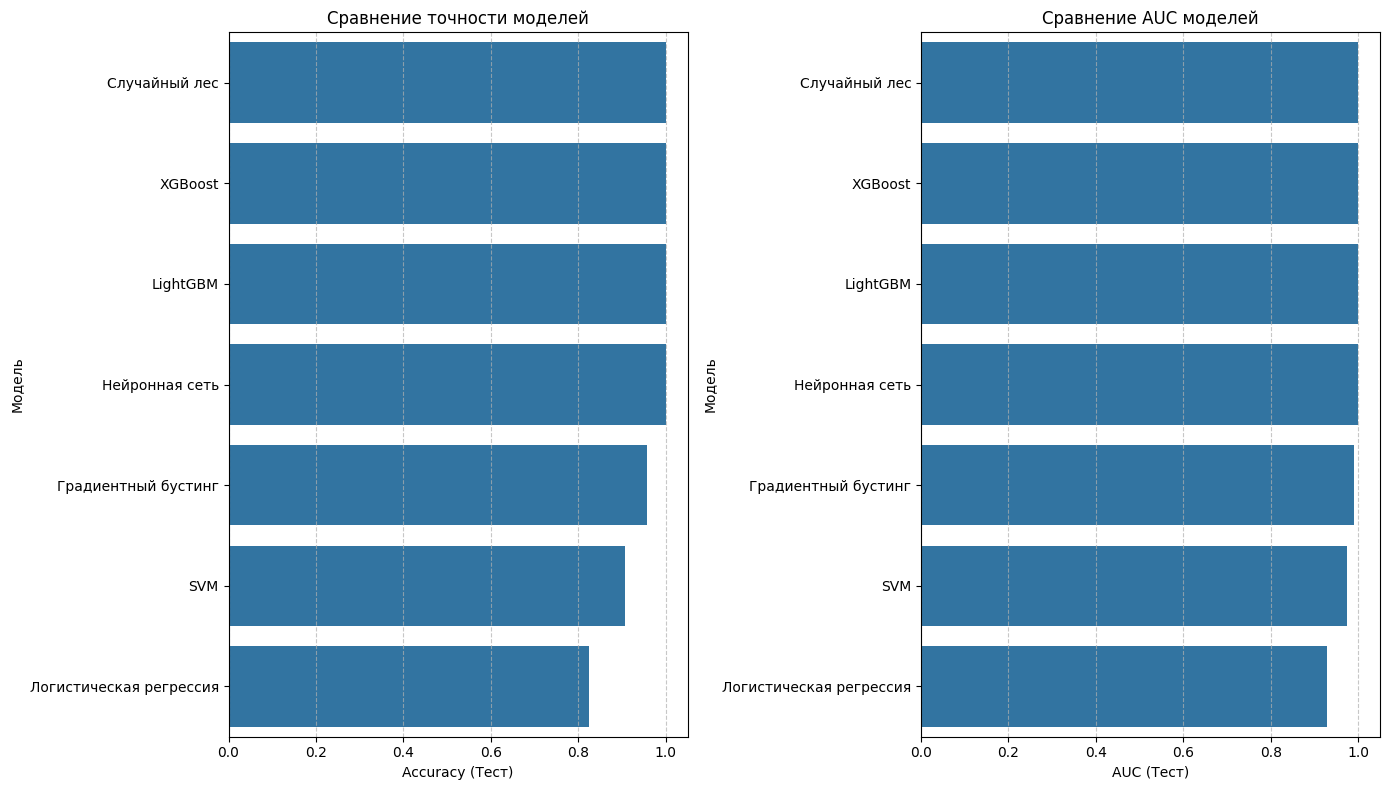

In [ ]:
# Визуализация результатов
plt.figure(figsize=(14, 8))

# Сравнение точности
plt.subplot(1, 2, 1)
sns.barplot(x='Accuracy (Тест)', y='Модель', data=results_df.sort_values(by='Accuracy (Тест)', ascending=False))
plt.title('Сравнение точности моделей')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Сравнение AUC
plt.subplot(1, 2, 2)
sns.barplot(x='AUC (Тест)', y='Модель', data=results_df.sort_values(by='AUC (Тест)', ascending=False))
plt.title('Сравнение AUC моделей')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()

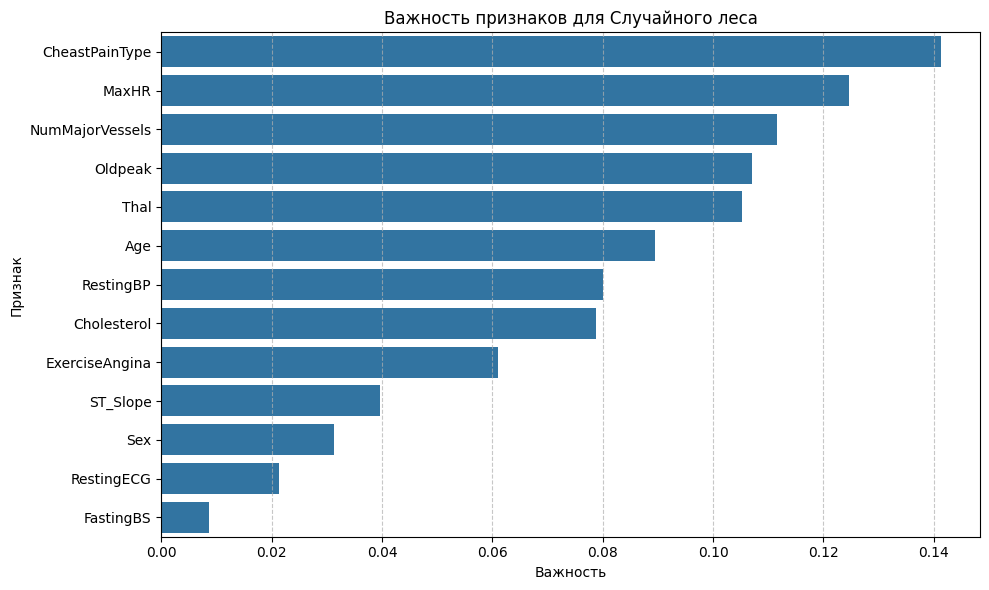

In [ ]:
# Анализ важности признаков для лучшей модели (Случайный лес)
model = models['Случайный лес']

importances = model.feature_importances_

feature_imp = pd.DataFrame({
    'Признак': X.columns,
    'Важность': importances
}).sort_values(by='Важность', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Важность', y='Признак', data=feature_imp)
plt.title(f'Важность признаков для Случайного леса')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Найдем оптимальные гиперпараметры для случайного леса
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(
    model, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
 # Оцениваем на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Точность на тестовой выборке: {test_accuracy:.4f}")
print(f"AUC на тестовой выборке: {test_auc:.4f}")

Точность на тестовой выборке: 1.0000
AUC на тестовой выборке: 1.0000
